<a href="https://colab.research.google.com/github/siting1206/NLP_HW1/blob/main/NER_Model_1104.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gensim.downloader as api
wv = api.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [ ]:
print(len(wv.vocab))

1193514


In [ ]:
vec = wv['pad']
print(vec)

[ 3.0424e-04 -1.3104e+00 -7.9360e-01 -2.4854e-01 -6.8530e-01  2.1971e-01
 -3.3586e-01 -1.0094e+00  1.3427e+00  5.3242e-01  4.7716e-01  1.1092e+00
 -2.4814e+00  4.2201e-01 -1.3752e-01  2.5775e-01  4.7288e-01  8.4469e-01
 -4.6955e-01  2.6217e-01 -7.8803e-01  3.0227e-01  4.1242e-01  2.2863e-01
 -6.3926e-01 -2.2236e-01 -9.9738e-01 -3.1988e-02  2.7116e-01 -3.9644e-01
  1.3877e-01 -4.5840e-01 -2.2790e-01 -4.0375e-01  1.2100e+00 -5.0365e-01
  8.6950e-01 -8.6008e-01 -1.3033e-01  1.8018e-01 -1.3445e-01  9.6773e-01
 -7.6972e-01  2.6810e-01  4.5365e-01  7.2944e-01  2.6386e-01 -3.5506e-01
 -5.8425e-02  3.5412e-01]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
import random
import collections

import matplotlib.pyplot as plt

from collections import namedtuple
from tensorflow.keras.preprocessing.sequence import pad_sequences

import regex as re
import os, string, sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class RegexFeatures(object):
    PATTERNS = {
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@[\p{Alnum}_]+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print("Initialized RegexFeature")
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features


Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences

def load_test_sequences(filename, sep="\t"):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
          line = line.strip()
          if line:
            seq.append(line)
          else:
            sequences.append(seq)
            seq = []
        if seq:
          sequences.append(seq)
    return sequences

In [ ]:
train_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/train.txt", sep="\t", notypes=True)
dev_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/dev.txt", sep="\t", notypes=False)
test_sequences = load_test_sequences("drive/MyDrive/NLP_assignment1/data/test-submit.txt", sep="\t")

In [ ]:
train_sentences = [[t[0] for t in seq] for seq in (train_sequences)]
train_tags = [[t[1] for t in seq] for seq in (train_sequences)]

valid_sentences = [[t[0] for t in seq] for seq in (dev_sequences)]
valid_tags = [[t[1] for t in seq] for seq in (dev_sequences)]
# print(train_sentences)

In [ ]:
other_entities = {
    "isHashtag": [],
    "isMention": [],
    "isURL": [],
    "isMoney": [],
    "isNumber": [],
    "repeatedPunctuation": []
}
for seq in train_sentences:
    for t in seq:
        for k in other_entities.keys():
            if RegexFeatures.PATTERNS[k].match(t):
                other_entities[k].append(t)
for k, v in other_entities.items():
    print(k, len(v))

isHashtag 440
isMention 1292
isURL 448
isMoney 5
isNumber 120
repeatedPunctuation 1059


In [ ]:
ENTITY_MAPPINGS={k: "__%s__" % k for k in other_entities.keys()}
ENTITY_MAPPINGS

{'isHashtag': '__isHashtag__',
 'isMention': '__isMention__',
 'isURL': '__isURL__',
 'isMoney': '__isMoney__',
 'isNumber': '__isNumber__',
 'repeatedPunctuation': '__repeatedPunctuation__'}

In [ ]:
def preprocess_token(x, to_lower=False):
    for k in ENTITY_MAPPINGS.keys():
        if RegexFeatures.PATTERNS[k].match(x):
            return ENTITY_MAPPINGS[k]
    if to_lower:
        x = x.lower()
    return x

In [ ]:
train_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in train_sequences]
dev_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in dev_sequences]
test_pre_seq = [[preprocess_token(t, to_lower=False) for t in seq] for seq in test_sequences]

In [ ]:
words = []
for seq in (train_pre_seq+dev_pre_seq):
  for word in seq:
    words.append(word)
print(len(words))

62730


In [ ]:
word2vec_sentences = [preprocess_token(t[0], to_lower=False) for seq in train_sequences for t in seq]
testtt = [preprocess_token(t, to_lower=False) for seq in test_sequences for t in seq]
tag2vec_sentences = [t[1] for seq in train_sequences for t in seq]
words=list(set(word2vec_sentences))
# print(word2vec_sentences)
tags=list(set(tag2vec_sentences))
# print(tags)
w_index={t:j for j,t in enumerate(words)}
t_index={t:j+1 for j,t in enumerate(tags)}
t_word={t+1:j for t,j in enumerate(tags)}
print(t_index)
n_words = len(w_index)
n_tags = len(t_index)
y_train = [[t_index[w[1]] for w in s] for s in train_sequences]
y_valid = [[t_index[w[1]] for w in s] for s in dev_sequences]

{'I-movie': 1, 'B-other': 2, 'I-person': 3, 'I-sportsteam': 4, 'O': 5, 'I-company': 6, 'I-tvshow': 7, 'I-musicartist': 8, 'B-company': 9, 'B-geo-loc': 10, 'B-movie': 11, 'B-musicartist': 12, 'B-person': 13, 'B-sportsteam': 14, 'B-facility': 15, 'B-product': 16, 'I-product': 17, 'I-other': 18, 'I-geo-loc': 19, 'I-facility': 20, 'B-tvshow': 21}


In [ ]:
train_maxl = max([len(s) for s in train_pre_seq])
dev_maxl = max([len(s) for s in dev_pre_seq])
# print ('Maximum length in the list of train_sentences:', train_maxl)
maxl = max(train_maxl, dev_maxl)

In [ ]:
embedding_matrix = wv.vectors
print(embedding_matrix.shape)

(1193514, 50)


In [ ]:
X_train = np.zeros([len(train_pre_seq), maxl], dtype='float32')
for i in range(len(train_pre_seq)):
  for j in range(min(len(train_pre_seq[i]),maxl)):
    try:
      X_train[i,j] = wv.vocab[train_pre_seq[i][j]].index
    except KeyError as e:
      X_train[i,j] = wv.vocab['unk'].index

X_valid = np.zeros([len(dev_pre_seq), maxl], dtype='float32')
for i in range(len(dev_pre_seq)):
  for j in range(min(len(dev_pre_seq[i]),maxl)):
    try:
      X_valid[i,j] = wv.vocab[dev_pre_seq[i][j]].index
    except KeyError as e:
      X_valid[i,j] = wv.vocab['unk'].index

X_test = np.zeros([len(test_pre_seq), maxl], dtype='float32')
for i in range(len(test_pre_seq)):
  for j in range(min(len(test_pre_seq[i]),maxl)):
    try:
      X_test[i,j] = wv.vocab[test_pre_seq[i][j]].index
    except KeyError as e:
      X_test[i,j] = wv.vocab['unk'].index

In [ ]:
from keras.utils import to_categorical
y_train = pad_sequences(maxlen=maxl, padding='post', sequences=y_train)
y_train = to_categorical(y_train) # (2394,41)->(2394,41,22)
print(X_train.shape, y_train.shape)

y_valid = pad_sequences(maxlen=maxl, padding='post', sequences=y_valid)
y_valid = to_categorical(y_valid) # (1000,41)->(1000,41,22)
print(X_valid.shape, y_valid.shape)

(2394, 41) (2394, 41, 22)
(1000, 41) (1000, 41, 22)


In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [47]:
input=Input(shape=maxl)
model=Embedding(len(wv.vocab), 50)(input)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=150,return_sequences=True, recurrent_dropout=0.1))(model)
output = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)

In [48]:
model=Model(input,output)

In [49]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=False
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 41)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 41, 50)            59675700  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 41, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 41, 300)          241200    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 41, 22)           6622      
 tributed)                                                       
                                                           

In [50]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

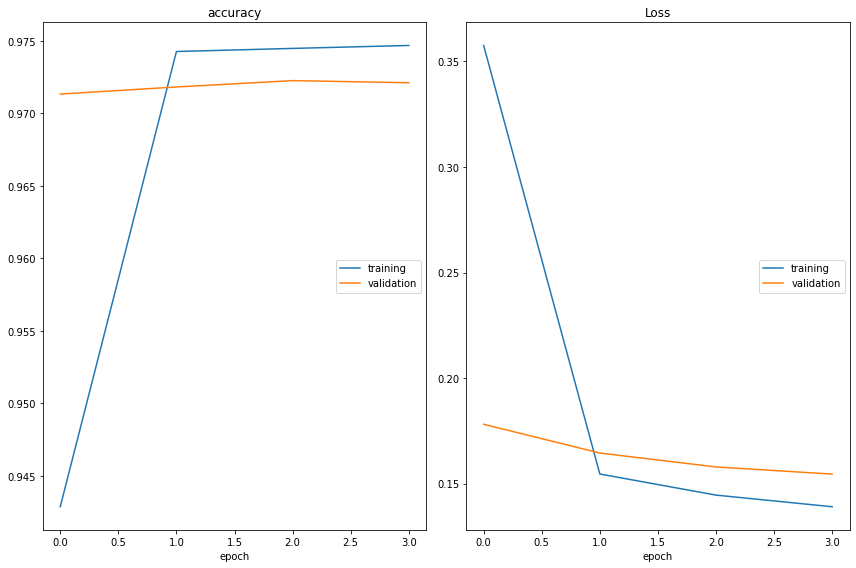

accuracy
	training         	 (min:    0.943, max:    0.975, cur:    0.975)
	validation       	 (min:    0.971, max:    0.972, cur:    0.972)
Loss
	training         	 (min:    0.139, max:    0.358, cur:    0.139)
	validation       	 (min:    0.155, max:    0.178, cur:    0.155)
75/75 [==============================] - 29s 385ms/step - loss: 0.1391 - accuracy: 0.9747 - val_loss: 0.1545 - val_accuracy: 0.9721


In [51]:
early_stop= EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stop]
history=model.fit(X_train,np.array(y_train), validation_data=(X_valid, np.array(y_valid)), batch_size=32, epochs=10, verbose=1, callbacks=callbacks)

In [ ]:
model.evaluate(X_train,np.array(y_train))

75/75 [==============================] - 3s 42ms/step - loss: 0.1313 - accuracy: 0.9749


[0.13125817477703094, 0.9748762249946594]

In [ ]:
print((len(X_test[0])))
p = model.predict(np.array([X_test[0]]))
p = np.argmax(p, axis=-1)
print(t_index)
print(wv.vocab['unk'].index)
wv.index2word[62980]

41
1/1 [==============================] - 1s 631ms/step
{'I-movie': 1, 'B-other': 2, 'I-person': 3, 'I-sportsteam': 4, 'O': 5, 'I-company': 6, 'I-tvshow': 7, 'I-musicartist': 8, 'B-company': 9, 'B-geo-loc': 10, 'B-movie': 11, 'B-musicartist': 12, 'B-person': 13, 'B-sportsteam': 14, 'B-facility': 15, 'B-product': 16, 'I-product': 17, 'I-other': 18, 'I-geo-loc': 19, 'I-facility': 20, 'B-tvshow': 21}
62980


'unk'

In [ ]:
true_tags = []
pred_tags = []
f = open("/content/drive/MyDrive/NLP_assignment1/data/output.txt", "w")
for i in range(0, len(X_valid)-1):
  pred = model.predict(np.array([X_valid[i]]))
  pred = np.argmax(pred, axis=-1)
  for j in range(0, maxl-1):
    if(pred[0][j]!=0):
      true_tags.append(valid_tags[i][j])
      pred_tags.append(t_word[pred[0][j]])
      f.write(valid_sentences[i][j] + " " + valid_tags[i][j] + " " + t_word[pred[0][j]] + "\n")
    else:
      f.write("\n")
      break
f.close()

1/1 [==============================] - 0s 38ms/step


## evaluating / dev 評估

In [ ]:
# !pip3 install datasets
# !wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

In [35]:
from conlleval import evaluate
# print out the table as above
evaluate(true_tags, pred_tags, verbose=True) 

# calculate overall metrics
prec, rec, f1 = evaluate(true_tags, pred_tags, verbose=False)

processed 16238 tokens with 661 phrases; found: 0 phrases; correct: 0.
accuracy:   0.00%; (non-O)
accuracy:  93.05%; precision:   0.00%; recall:   0.00%; FB1:   0.00
          company: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
         facility: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
          geo-loc: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            other: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           person: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
          product: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
       sportsteam: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
